# **VIRTUAL RACE ENGINEER**

In [2]:
import fastf1 as ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastf1.plotting
fastf1.plotting.setup_mpl()
import fastf1.api as fap
fastf1.Cache.enable_cache(r"D:\Prabhu\SEM 7\F1 Data")
import re
import datetime as dt
import fastf1.mvapi as famp
import fastf1.events as fae
import plotly.express as px

d:\Prabhu\SEM 7\F1 Data\.venv\Lib\site-packages\fastf1\api.py:32: UserWarning: `fastf1.api` will be considered private in future releases and potentially be removed or changed!
  warnings.warn("`fastf1.api` will be considered private in future releases and "


### LOADING SESSION

In [3]:
session = ff.get_session(2023,'Dutch','R')
session.load()
session_start_time=session.t0_date

core           INFO 	Loading data for Dutch Grand Prix - Race [v3.3.7]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']


In [66]:
laps=session.laps
drivers=laps['Driver'].unique()

### FETCHING TELEMETRY DATA 

In [5]:
total_telemetry=[]
for i in drivers:
    drivers_laps=laps.pick_driver(i)
    driver_telemetry=drivers_laps.get_car_data()
    
    driver_telemetry['Driver']=i
    total_telemetry.append(driver_telemetry)
telemetry_data=pd.concat(total_telemetry,ignore_index=True)

### FETCHING WEATHER,TYRE,LAP AND POSITION DATA 

In [6]:
weather_data=pd.DataFrame(fap.weather_data(session.api_path))
tyre_data = laps[['Driver', 'LapNumber', 'Compound', 'FreshTyre','TyreLife']]
lap_data=laps[['Time','Driver','DriverNumber','LapNumber','LapTime','Sector1Time','Sector2Time','Sector3Time','IsAccurate']]
position_data=laps[['Driver','DriverNumber','LapNumber','Position','LapStartTime']]

req            INFO 	Using cached data for weather_data


### FETCHING RACE CONTROL MESSAGES

In [7]:
rcm_data = pd.DataFrame(fap.race_control_messages(session.api_path))
master_msg=rcm_data[['Time','Category','Flag','Status','Message']]

req            INFO 	Using cached data for race_control_messages


In [8]:
# #Filter for Yellow, Red, VSC, SC 
# yellow_flags_key=['YELLOW','DOUBLE YELLOW']
# red_flags_key=['RED']
# vsc_key=['VSC','VIRTUAL SAFETY CAR']
# sc_key=['SC','SAFETY CAR']

# #Searching using the keyword in REGEX
# yellow_flags = msg[msg['Message'].apply(lambda x: any(re.search(r'\b{}\b'.format(keyword), x) for keyword in yellow_flags_key))]
# red_flags = msg[msg['Message'].apply(lambda x: any(re.search(r'\b{}\b'.format(keyword), x) for keyword in red_flags_key))]
# vsc = msg[msg['Message'].apply(lambda x: any(re.search(r'\b{}\b'.format(keyword), x) for keyword in vsc_key))]
# sc = msg[msg['Message'].apply(lambda x: any(re.search(r'\b{}\b'.format(keyword), x) for keyword in sc_key))]
# master_msg=pd.concat([yellow_flags,red_flags,vsc,sc], axis=0)

# pd.set_option('display.max_columns', None)

### FETCHING LAP DATA (PITS STOPS, DRIVER POSITION ETC.)

In [9]:
lapsdata, streamdata = fap.timing_data(session.api_path)
lapsdata=pd.DataFrame(lapsdata)
lapsdata['DriverNumber'] = lapsdata['Driver']
gapdata=pd.DataFrame(streamdata)
gapdata['DriverNumber'] = gapdata['Driver']
gap_data = gapdata[['Time','DriverNumber','Position','GapToLeader','IntervalToPositionAhead']]
laps_data=lapsdata[['Time','DriverNumber','LapTime','NumberOfPitStops','PitOutTime','PitInTime']]

req            INFO 	Using cached data for _extended_timing_data


### GETTING CORNERS INFO

In [10]:
circuit_info=session.get_circuit_info()
corners_data=circuit_info.corners

### MAKING A MASTER DATA (POSITION DATA, POSITION DATA, LAPS DATA)
###### NOTE:WE ARE KEEPING THE GAP DATA, WEATHER DATA, RACE CONTROL MESSAGES AND THE TELEMETRY DATA SEPERATE BECAUSE EACH DATA IS GENERATED IN A COMPLETELY DIFFERENT TIME

In [11]:
master_data = lap_data.merge(position_data, on=['Driver', 'DriverNumber', 'LapNumber'], how='left')
master_data = master_data.merge(tyre_data, on=['Driver', 'LapNumber'], how='left')
master_data = master_data.merge(laps_data, on=['DriverNumber','Time','LapTime'], how='left')

#### FILLING THE MISSING LAPTIME VALUES WITH BACKWARD FILL

In [12]:
columns_to_fill=['LapTime','Sector1Time','Sector2Time','Sector3Time']
master_data[columns_to_fill]=master_data[columns_to_fill].fillna(method='bfill')

C:\Users\prabh\AppData\Local\Temp\ipykernel_15720\3161052701.py:2: FutureWarning: Laps.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  master_data[columns_to_fill]=master_data[columns_to_fill].fillna(method='bfill')


### CONVERTING TIME TO SECONDS

In [13]:
master_data['Sector1Time(s)']=master_data['Sector1Time'].dt.total_seconds()
master_data['Sector2Time(s)']=master_data['Sector2Time'].dt.total_seconds()
master_data['Sector3Time(s)']=master_data['Sector3Time'].dt.total_seconds()
master_data['Cum.SectorTime(s)']=master_data['Sector1Time(s)']+master_data['Sector2Time(s)']+master_data['Sector3Time(s)']
master_data['LapTime(s)']=master_data['LapTime'].dt.total_seconds()
master_data['LapStartTime(s)']=master_data['LapStartTime'].dt.total_seconds()
master_data['PitInTime(s)']=master_data['PitInTime'].dt.total_seconds()
master_data['PitOutTime(s)']=master_data['PitOutTime'].dt.total_seconds().shift(-1)

#### CALCULATING PITSTOP TIME AND LAP DELTA

In [14]:
master_data['PitStopTime(s)']=master_data['PitOutTime(s)']-master_data['PitInTime(s)']
master_data['PrevLapTime(s)']=master_data['LapTime(s)'].shift(1)
master_data['LapΔ(s)']=master_data['LapTime(s)']-master_data['PrevLapTime(s)']

In [15]:
master_data=master_data.sort_values(by=['LapNumber','Position'])
master_data['CumLapTime(s)'] = master_data.groupby('Driver')['LapTime(s)'].cumsum()

#### DEFINING FUNCTION TO CALCULATE GAP TO LEADER AND INTERVAL AT THE END OF EACH LAP

In [16]:
def gap_and_interval(df):
    gap_to_leader=[]
    interval=[]
    for i in df['LapNumber'].unique():
        lap=df[df['LapNumber']==i]
        leader_time=lap.iloc[0]['CumLapTime(s)']
        lap.loc[:,'GapToLeader']=lap['CumLapTime(s)']-leader_time
        lap.loc[:,'Interval']=lap['CumLapTime(s)'].diff().fillna(0)
        gap_to_leader.extend(lap['GapToLeader'].tolist())
        interval.extend(lap['Interval'].tolist())
    return gap_to_leader,interval
master_data['GapToLeader'],master_data['Interval']=gap_and_interval(master_data)
master_data.loc[master_data['Position']==1,'GapToLeader']=0
master_data.loc[master_data['Position']==1,'Interval']=0

C:\Users\prabh\AppData\Local\Temp\ipykernel_15720\4238679693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap.loc[:,'GapToLeader']=lap['CumLapTime(s)']-leader_time
C:\Users\prabh\AppData\Local\Temp\ipykernel_15720\4238679693.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap.loc[:,'Interval']=lap['CumLapTime(s)'].diff().fillna(0)
C:\Users\prabh\AppData\Local\Temp\ipykernel_15720\4238679693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

#### SCALING AND NORMALIZING THE DATA

In [17]:
# from sklearn.preprocessing import RobustScaler
# scaler=RobustScaler()
# toscale=['LapTime(s)', 'Sector1Time(s)', 'Sector2Time(s)', 'Sector3Time(s)', 
#                     'CumLapTime(s)', 'GapToLeader', 'Interval', 'LapStartTime(s)', 
#                     'PitInTime(s)', 'PitOutTime(s)', 'PitStopTime(s)', 'PrevLapTime(s)', 'LapΔ(s)','FreshTyre','NumberOfPitStops','TyreLife']
# master_data[toscale] = scaler.fit_transform(master_data[toscale])
# telemetry_columns_to_scale = ['Speed', 'Throttle', 'Brake', 'nGear', 'RPM', 'DRS']
# telemetry_data[telemetry_columns_to_scale] = scaler.fit_transform(telemetry_data[telemetry_columns_to_scale])
# weather_columns_to_scale = ['AirTemp', 'TrackTemp', 'Humidity', 'Pressure', 'WindSpeed', 'WindDirection','Rainfall']
# weather_data[weather_columns_to_scale] = scaler.fit_transform(weather_data[weather_columns_to_scale])

#### FINDING MISSING DATA

In [18]:
master_missing=master_data.isnull().sum()
telemetry_missing=telemetry_data.isnull().sum()
weather_missing=weather_data.isnull().sum()

#### FILLING MISSING PITSTOP DATA 

In [19]:
colums_to_fill_zero=['NumberOfPitStops','PitInTime','PitOutTime','PitInTime(s)','PitOutTime(s)','PitStopTime(s)','PrevLapTime(s)','LapΔ(s)']
master_data[colums_to_fill_zero]=master_data[colums_to_fill_zero].fillna(0)

#### ENCODING CATEGORICAL REPRESENTATION

In [20]:
from sklearn.preprocessing import OneHotEncoder
master_data=pd.get_dummies(master_data,columns=['Compound'])

In [21]:
master_msg=pd.get_dummies(master_msg,columns=['Category','Flag'])
master_msg['Time'] = master_msg['Time'] - session_start_time

In [22]:
master_data

,Time,Driver,DriverNumber,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,IsAccurate,Position,...,PrevLapTime(s),LapΔ(s),CumLapTime(s),GapToLeader,Interval,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET
0,0 days 01:03:36.820000,VER,1,1.0,0 days 00:01:31.585000,0 days 00:00:36.330000,0 days 00:00:28.929000,0 days 00:00:30.478000,False,1.0,...,0.000,0.000,91.585,0.000,0.000,False,False,False,True,False
839,0 days 01:03:37.462000,NOR,4,1.0,0 days 00:01:32.227000,0 days 00:00:37.353000,0 days 00:00:28.594000,0 days 00:00:30.567000,False,2.0,...,83.205,9.022,92.227,0.642,0.642,False,False,False,True,False
216,0 days 01:03:38.001000,ALO,14,1.0,0 days 00:01:32.766000,0 days 00:00:36.326000,0 days 00:00:28.764000,0 days 00:00:30.590000,False,3.0,...,81.699,11.067,92.766,1.181,0.539,False,False,False,True,False
1127,0 days 01:03:38.476000,RUS,63,1.0,0 days 00:01:33.241000,0 days 00:00:37.093000,0 days 00:00:28.820000,0 days 00:00:30.679000,False,4.0,...,82.652,10.589,93.241,1.656,0.475,False,False,False,True,False
560,0 days 01:03:39.511000,ALB,23,1.0,0 days 00:01:34.276000,0 days 00:00:36.857000,0 days 00:00:29.096000,0 days 00:00:31.301000,False,5.0,...,83.883,10.393,94.276,2.691,1.035,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,0 days 03:26:34.603000,TSU,22,72.0,0 days 00:01:23.883000,0 days 00:00:28.923000,0 days 00:00:28.789000,0 days 00:00:26.171000,True,13.0,...,83.101,0.782,6247.044,90.151,-0.399,False,True,False,False,False
982,0 days 03:26:35.827000,LAW,40,72.0,0 days 00:01:23.592000,0 days 00:00:28.792000,0 days 00:00:28.745000,0 days 00:00:26.055000,True,14.0,...,84.122,-0.530,6261.330,104.437,14.286,False,True,False,False,False
487,0 days 03:26:36.084000,MAG,20,72.0,0 days 00:01:23.550000,0 days 00:00:29.009000,0 days 00:00:28.794000,0 days 00:00:25.747000,True,15.0,...,83.912,-0.362,6315.824,158.931,54.494,False,True,False,False,False
1270,0 days 03:26:37.061000,BOT,77,72.0,0 days 00:01:23.030000,0 days 00:00:28.882000,0 days 00:00:28.443000,0 days 00:00:25.705000,True,16.0,...,82.873,0.157,6255.933,99.040,-59.891,False,True,False,False,False


In [23]:
telemetry_data

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Driver
0,2023-08-27 13:03:05.416,10093,0,1,15,False,1,car,0 days 00:00:00.082000,0 days 01:02:05.042000,VER
1,2023-08-27 13:03:05.616,10063,0,1,15,False,1,car,0 days 00:00:00.282000,0 days 01:02:05.242000,VER
2,2023-08-27 13:03:05.897,8517,1,1,15,False,1,car,0 days 00:00:00.563000,0 days 01:02:05.523000,VER
3,2023-08-27 13:03:06.097,7117,11,1,15,False,1,car,0 days 00:00:00.763000,0 days 01:02:05.723000,VER
4,2023-08-27 13:03:06.497,4317,24,1,16,False,1,car,0 days 00:00:01.163000,0 days 01:02:06.123000,VER
...,...,...,...,...,...,...,...,...,...,...,...
601328,2023-08-27 15:27:25.367,11670,294,7,99,False,1,car,0 days 02:24:20.033000,0 days 03:26:24.993000,PIA
601329,2023-08-27 15:27:25.527,11699,295,7,99,False,1,car,0 days 02:24:20.193000,0 days 03:26:25.153000,PIA
601330,2023-08-27 15:27:25.687,11742,295,7,99,False,1,car,0 days 02:24:20.353000,0 days 03:26:25.313000,PIA
601331,2023-08-27 15:27:26.047,11758,296,7,99,False,1,car,0 days 02:24:20.713000,0 days 03:26:25.673000,PIA


In [24]:
weather_data

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:46.338000,17.4,68.0,1007.4,False,25.5,196,2.7
1,0 days 00:01:46.337000,17.4,67.0,1007.5,False,25.5,193,3.2
2,0 days 00:02:46.336000,17.4,66.0,1007.4,False,25.5,177,3.4
3,0 days 00:03:46.335000,17.5,67.0,1007.4,False,25.6,184,2.4
4,0 days 00:04:46.349000,17.5,67.0,1007.5,False,25.6,186,2.9
...,...,...,...,...,...,...,...,...
204,0 days 03:24:47.183000,15.7,79.0,1008.2,True,19.0,176,3.0
205,0 days 03:25:47.182000,15.8,77.0,1008.2,True,19.1,161,3.0
206,0 days 03:26:47.181000,15.8,77.0,1008.2,True,19.1,163,2.7
207,0 days 03:27:47.180000,15.7,74.0,1008.4,False,18.9,192,3.2


#### MERGING ALL DATA WITH MASTER DATA

In [25]:
master_data_sorted=master_data.sort_values('Time')
master_msg_sorted=master_msg.sort_values('Time')
merged_data = pd.merge_asof(master_data_sorted, weather_data, left_on='Time', right_on='Time', direction='nearest')
merged_data=pd.merge_asof(merged_data, master_msg_sorted, left_on='Time', right_on='Time', direction='nearest')
pd.set_option('display.max_columns', None)
# merged_data.to_excel('merged_data.xlsx', index=False)

#### FILLING THE NULL VALUES IN STATUS WITH TRACK CLEAR

In [26]:
merged_data_missing=merged_data.isnull().sum()
merged_data[['Status']]=merged_data[['Status']].fillna("TRACK CLEAR")
merged_data_missing=merged_data.isnull().sum()

#### DRIVERS AND THEIR TEAMS

In [77]:
driver_team_map = {
    'VER': 'RedBull',
    'PER': 'RedBull',
    'HAM': 'Mercedes',
    'RUS': 'Mercedes',
    'LEC': 'Ferrari',
    'SAI': 'Ferrari',
    'NOR': 'Mclaren',
    'PIA': 'Mclaren',
    'ALO': 'Aston Martin',
    'STR': 'Aston Martin',
    'OCO': 'Alpine',
    'GAS': 'Alpine',
    'TSU': 'VCARB',
    'RIC': 'VCARB',
    'LAW': 'VCARB',
    'MAG': 'Haas',
    'HUL': 'Haas',
    'BOT': 'Sauber',
    'ZHO': 'Sauber',
    'SAR': 'Williams',
    'ALB': 'Williams'

}

#### GETTING THE TEAM COLOR OF THE DRIVER

In [78]:
def get_team_color(driver):
    team = driver_team_map.get(driver, 'Unknown')
    if team == 'Unknown':
        return 'black'
    return ff.plotting.team_color(team)

#### DRIVERS TO PLOT

In [80]:
drivers_to_plot = ['LAW', 'ALB']

#### LAP TIME PLOTTING BETWEEN DRIVERS USING MATPLOTLIB

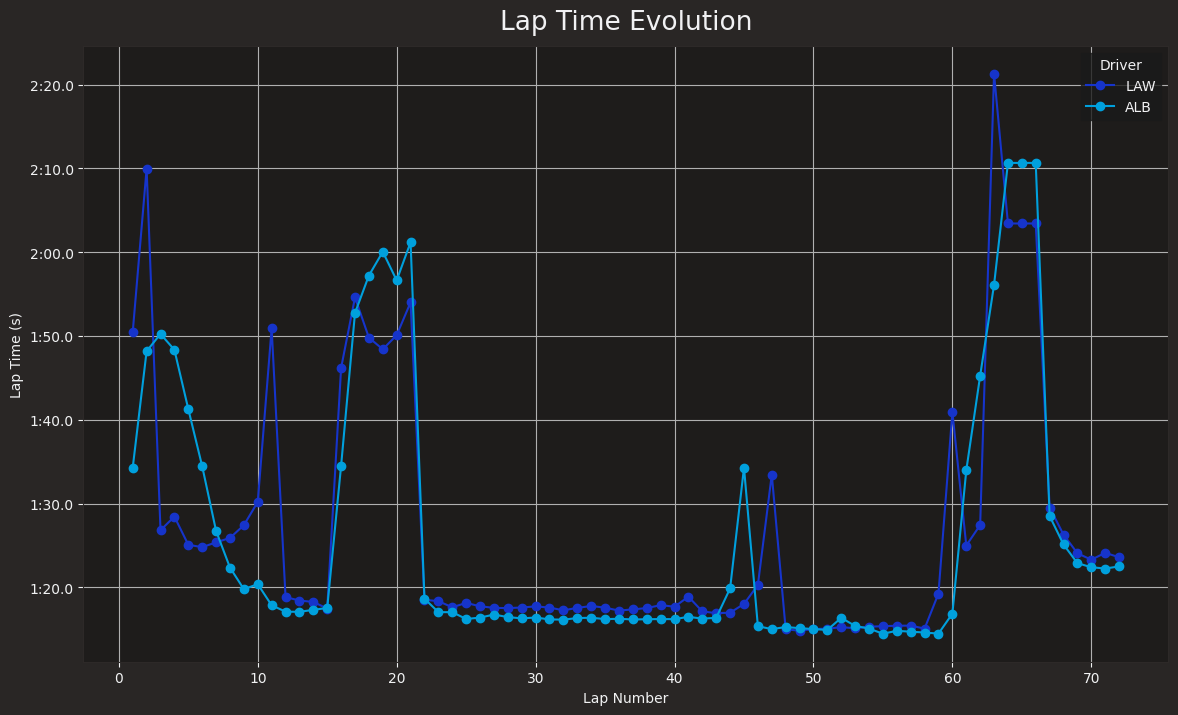

In [81]:
plt.figure(figsize=(14, 8))
for driver in drivers_to_plot:
    driver_data = merged_data[merged_data['Driver'] == driver]
    team_color = get_team_color(driver)
    plt.plot(driver_data['LapNumber'], driver_data['LapTime'], marker='o', label=driver, color=team_color)

plt.title('Lap Time Evolution')
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (s)')
plt.legend(title='Driver')
plt.grid(True)
plt.show()

In [82]:
merged_data

,Time,Driver,DriverNumber,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,IsAccurate,Position,LapStartTime,FreshTyre,TyreLife,NumberOfPitStops,PitOutTime,PitInTime,Sector1Time(s),Sector2Time(s),Sector3Time(s),Cum.SectorTime(s),LapTime(s),LapStartTime(s),PitInTime(s),PitOutTime(s),PitStopTime(s),PrevLapTime(s),LapΔ(s),CumLapTime(s),GapToLeader,Interval,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Status,Message,Category_CarEvent,Category_Drs,Category_Flag,Category_Other,Category_SafetyCar,Flag_BLACK AND WHITE,Flag_BLUE,Flag_CHEQUERED,Flag_CLEAR,Flag_DOUBLE YELLOW,Flag_GREEN,Flag_RED,Flag_YELLOW
0,0 days 01:03:36.820000,VER,1,1.0,0 days 00:01:31.585000,0 days 00:00:36.330000,0 days 00:00:28.929000,0 days 00:00:30.478000,False,1.0,0 days 01:02:04.960000,True,1.0,0.0,0,0,36.330,28.929,30.478,95.737,91.585,3724.960,0.0,0.0,0.0,0.000,0.000,91.585,0.000,0.000,False,False,False,True,False,17.5,67.0,1007.7,True,28.6,157,1.7,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
1,0 days 01:03:37.462000,NOR,4,1.0,0 days 00:01:32.227000,0 days 00:00:37.353000,0 days 00:00:28.594000,0 days 00:00:30.567000,False,2.0,0 days 01:02:04.960000,True,1.0,0.0,0,0,37.353,28.594,30.567,96.514,92.227,3724.960,0.0,0.0,0.0,83.205,9.022,92.227,0.642,0.642,False,False,False,True,False,17.5,67.0,1007.7,True,28.6,157,1.7,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
2,0 days 01:03:38.001000,ALO,14,1.0,0 days 00:01:32.766000,0 days 00:00:36.326000,0 days 00:00:28.764000,0 days 00:00:30.590000,False,3.0,0 days 01:02:04.960000,True,1.0,0.0,0,0,36.326,28.764,30.590,95.680,92.766,3724.960,0.0,0.0,0.0,81.699,11.067,92.766,1.181,0.539,False,False,False,True,False,17.5,67.0,1007.7,True,28.6,157,1.7,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
3,0 days 01:03:38.476000,RUS,63,1.0,0 days 00:01:33.241000,0 days 00:00:37.093000,0 days 00:00:28.820000,0 days 00:00:30.679000,False,4.0,0 days 01:02:04.960000,True,1.0,0.0,0,0,37.093,28.820,30.679,96.592,93.241,3724.960,0.0,0.0,0.0,82.652,10.589,93.241,1.656,0.475,False,False,False,True,False,17.5,67.0,1007.7,True,28.6,157,1.7,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
4,0 days 01:03:39.511000,ALB,23,1.0,0 days 00:01:34.276000,0 days 00:00:36.857000,0 days 00:00:29.096000,0 days 00:00:31.301000,False,5.0,0 days 01:02:04.960000,True,1.0,0.0,0,0,36.857,29.096,31.301,97.254,94.276,3724.960,0.0,0.0,0.0,83.883,10.393,94.276,2.691,1.035,False,False,False,True,False,17.5,67.0,1007.7,True,28.6,157,1.7,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,0 days 03:26:34.603000,TSU,22,72.0,0 days 00:01:23.883000,0 days 00:00:28.923000,0 days 00:00:28.789000,0 days 00:00:26.171000,True,13.0,0 days 03:25:10.720000,False,14.0,5.0,0,0,28.923,28.789,26.171,83.883,83.883,12310.720,0.0,0.0,0.0,83.101,0.782,6247.044,90.151,-0.399,False,True,False,False,False,15.8,77.0,1008.2,True,19.1,163,2.7,TRACK CLEAR,CHEQUERED FLAG,False,False,True,False,False,False,False,True,False,False,False,False,False
1339,0 days 03:26:35.827000,LAW,40,72.0,0 days 00:01:23.592000,0 days 00:00:28.792000,0 days 00:00:28.745000,0 days 00:00:26.055000,True,14.0,0 days 03:25:12.235000,False,16.0,7.0,0,0,28.792,28.745,26.055,83.592,83.592,12312.235,0.0,0.0,0.0,84.122,-0.530,6261.330,104.437,14.286,False,True,False,False,False,15.8,77.0,1008.2,True,19.1,163,2.7,TRACK CLEAR,CHEQUERED FLAG,False,False,True,False,False,False,False,True,Fal

#### LAP TIME PLOTTING BETWEEN DRIVERS USING PLOTLY

In [83]:
# Format y-axis labels in intervals of 10 seconds
def format_yaxis_labels(value):
    minutes = int(value // 60)
    seconds = int(value % 60)
    milliseconds = int((value % 1) * 1000)
    return f'{minutes}:{seconds:02}.{milliseconds:03}'

# Prepare data for plotting
plot_data_list = []
for driver in drivers_to_plot:
    driver_data = merged_data[merged_data['Driver'] == driver].copy()
    driver_data['LapTime_sec'] = driver_data['LapTime'].dt.total_seconds()
    driver_data['TeamColor'] = get_team_color(driver)
    driver_data['Minutes'] = driver_data['LapTime_sec'] // 60
    driver_data['Seconds'] = driver_data['LapTime_sec'] % 60
    driver_data['Milliseconds'] = (driver_data['LapTime_sec'] % 1) * 1000
    plot_data_list.append(driver_data)

plot_data = pd.concat(plot_data_list, ignore_index=True)

# Determine y-axis tick values for intervals of 10 seconds
max_lap_time_sec = plot_data['LapTime_sec'].max()
y_tick_values = list(range(0, int(max_lap_time_sec) + 10, 10))

# Create line plot with markers
fig = px.line(
    plot_data,
    x='LapNumber',
    y='LapTime_sec',
    color='Driver',
    hover_data={
        'LapTime_sec': False,  # We'll customize this below
        'LapNumber': True,
        'TeamColor': False,
        'Driver': True,
        'Minutes': True,
        'Seconds': True,
        'Milliseconds': True
    },
    title='Lap Time Evolution',
    labels={
        'LapNumber': 'Lap Number',
        'LapTime_sec': 'Lap Time'
    },
    markers=True,
    color_discrete_map={driver: get_team_color(driver) for driver in drivers_to_plot}
)

# Update hover template to format lap time
fig.update_traces(
    hovertemplate='<b>Driver</b>: %{customdata[1]}<br>' +
                  '<b>Lap Number</b>: %{x}<br>' +
                  '<b>Lap Time</b>: %{customdata[2]}:%{customdata[3]:02.0f}.%{customdata[4]:03.0f}<extra></extra>'
)

# Update y-axis to use formatted labels at 10-second intervals
fig.update_yaxes(
    tickvals=y_tick_values,
    ticktext=[format_yaxis_labels(val) for val in y_tick_values],
    title='Lap Time (min:sec.msec)'
)

# Show plot
fig.show()